# CS189 Final Project

Members:

Timothy Quang Nguyen, timotqn2@uci.edu

Aditya Pal Singh, adityapa@uci.edu

## Environment Setup

In [48]:
# # For package installations
# !pip install xgboost
# !pip install scikit-optimize
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install tensorflow
# !pip install shap

In [49]:
import numpy as np # for data organization
import pandas as pd # for data organization
import sklearn as sk # for machine learning
from sklearn.metrics import (confusion_matrix, accuracy_score, 
                            precision_score, recall_score, 
                            f1_score, roc_auc_score,
                            matthews_corrcoef, balanced_accuracy_score) # For Evaluation
from sklearn.preprocessing import MinMaxScaler # To Scale Features
from sklearn.preprocessing import OneHotEncoder, StandardScaler # To Encode Non-Numeric Columns
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score # For Hyper Parameter Tuning and Data Splitting
from skopt import BayesSearchCV # For Smart Hyper Parameter Tuning
from sklearn.linear_model import LogisticRegression # For Logistic Regression
from sklearn.ensemble import RandomForestClassifier # For Random Forest Classifier
from sklearn.svm import SVC # For Support Vector Classifier
from xgboost import XGBClassifier # For XGB Classifier
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import zipfile as zf # for unzipping data
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [50]:
# Code to extract dataset from zip (Don't need to run)

files = zf.ZipFile('archive.zip', 'r')
files.extractall('dataset')
files.close()

### Function Declaration

In [51]:
def evaluate_medical_model(y_true, y_pred, y_pred_proba=None, 
                          label_nums=[0,1], label_names=['Benign', 'Malignant']):
    """
    Comprehensive evaluation for medical binary classification.
    
    Parameters:
        y_true: True labels (array-like)
        y_pred: Predicted labels (array-like)
        y_pred_proba: Predicted probabilities (optional, for ROC-AUC)
        label_nums: Numeric labels [negative_class, positive_class]
        label_names: Descriptive label names
    """
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=label_nums)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=label_names, 
                yticklabels=label_names,
                annot_kws={"size": 14})
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()

    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Precision (PPV)': precision_score(y_true, y_pred),
        'Recall (Sensitivity)': recall_score(y_true, y_pred),
        'Specificity': tn / (tn + fp),
        'F1 Score': f1_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred_proba)

    # Print formatted metrics
    print("\nMEDICAL DIAGNOSTICS METRICS")
    print("="*40)
    for name, value in metrics.items():
        if name in ['ROC-AUC', 'MCC']:  # Metrics that don't use percentage
            print(f"{name:<25}: {value:.4f}")
        else:
            print(f"{name:<25}: {value:.2%}")
    
    # Critical medical stats
    print("\nCRITICAL MEDICAL STATISTICS")
    print("="*40)
    print(f"False Negatives (Missed Cancer): {fn}")
    print(f"False Positives (Overdiagnosis): {fp}")
    print(f"Sensitivity (True Positive Rate): {metrics['Recall (Sensitivity)']:.2%}")
    print(f"Specificity (True Negative Rate): {metrics['Specificity']:.2%}")

In [52]:
# Used to produce confusion matrices and accuracy metrics for models
def confusion_matrix_and_metrics(y_te, y_pred, label_nums, label_names):
    
    # Used to produce a pretty Confusion Matrix
    cm = confusion_matrix(y_te, y_pred, labels=label_nums)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Used to produce metric data, precision, recall, F1 score, accuracy

    print("Precision of the MLP :\t" + str(precision_score(y_te, y_pred, average="macro")))
    print("Recall of the MLP    :\t" + str(recall_score(y_te, y_pred, average="macro")))
    print("F1 Score of the Model :\t" + str(f1_score(y_te, y_pred, average="macro")))
    print("Accuracy Score of the Model :\t" + str(round(accuracy_score(y_te, y_pred) * 100, 2)) + "%")

In [53]:
# To showcase general data properties
def print_general_data_properties(data):
    rows, cols = data.shape

    print("Number of rows: ", rows)
    print("Number of columns: ", cols)
    print()
    print("All Columns:\n", data.columns)
    print()
    print("Column Types:\n", data.dtypes)

## Loading Data

In [54]:
# Define paths (adjust as needed)
train_path = './dataset/Features_Train.csv'
test_path = './dataset/Lung Nodule/Lung Nodule/Features_Test.csv'

# Load data with error handling
try:
    train_data = pd.read_csv(train_path)
    print("Train data loaded successfully. Shape:", train_data.shape)
except FileNotFoundError:
    print(f"Error: {train_path} not found. Check the path or Kaggle dataset structure.")

try:
    test_data = pd.read_csv(test_path)
    print("Test data loaded successfully. Shape:", test_data.shape)
except FileNotFoundError:
    print(f"Error: {test_path} not found. Ensure the path matches the Kaggle folder.")

Train data loaded successfully. Shape: (609, 2000)
Test data loaded successfully. Shape: (127, 2000)


## Exploring Data

In [55]:
# Basic info
df = pd.read_csv(train_path)  
print("="*50)
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
display(df.head())

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values per Column:")
print(df.isnull().sum())

print("\nDescriptive Statistics:")
display(df.describe(include='all'))

Dataset Shape: (609, 2000)

First 5 Rows:


ID  Annulus_N.voxels  Annulus_SNS_vol  Annulus_SNS_area  \
0  0001_1              1504             1504              3364   
1  0003_1              1007             1007              2224   
2  0004_1              2160             2160              4322   
3  0005_1              1568             1568              3276   
4  0006_1               779              779              1702   

   Annulus_SNS_s2v  Annulus_SNS_sph  Annulus_SNS_sph_dis  Annulus_SNS_com_1  \
0         2.236702         0.188709             5.299155           3.779511   
1         2.208540         0.218459             4.577528           3.334505   
2         2.000926         0.186969             5.348493           4.592921   
3         2.089286         0.199237             5.019137           4.010592   
4         2.184852         0.240556             4.157036           3.083113   

   Annulus_SNS_com_2  Annulus_SNS_max3d  ...  Lesion_GLCM_sumEnt_HHH_25HUgl  \
0           0.006720                 21  ...                       1.456343   
1           0.010426                 16  ...                       1.462379   
2           0.006536                 17  ...                       1.050196   
3           0.007909                 23  ...                       1.157852   
4           0.013920                 14  ...                       1.414994   

   Lesion_GLCM_difVar_HHH_25HUgl  Lesion_GLCM_difEnt_HHH_25HUgl  \
0                       0.516489                       1.478822   
1                       0.535239                       1.502895   
2                       0.245968                       0.988000   
3                       0.299988                       1.146312   
4                       0.484908                       1.434273   

   Lesion_GLCM_AutoCorrel_HHH_25HUgl  Lesion_GLCM_ClTend_HHH_25HUgl  \
0                          12.359264                       1.122325   
1                          12.134616                       1.132018   
2                           2.261923                       0.527141   
3                           6.241820                       0.605958   
4                           6.282063                       1.046868   

   Lesion_GLCM_Homoge1_HHH_25HUgl  Lesion_GLCM_IDMN_HHH_25HUgl  \
0                        0.672912                     0.972564   
1                        0.675078                     0.971933   
2                        0.763604                     0.905442   
3                        0.733500                     0.965438   
4                        0.692436                     0.964913   

   Lesion_GLCM_IDN_HHH_25HUgl  Lesion_GLCM_invVar_HHH_25HUgl  Outcome  
0                    0.898164                       0.519051        0  
1                    0.898085                       0.502191        0  
2                    0.842403                       0.472791        1  
3                    0.891646                       0.504706        1  
4                    0.889447                       0.487179        0  

[5 rows x 2000 columns]


Data Types:
ID                                 object
Annulus_N.voxels                    int64
Annulus_SNS_vol                     int64
Annulus_SNS_area                    int64
Annulus_SNS_s2v                   float64
                                   ...   
Lesion_GLCM_Homoge1_HHH_25HUgl    float64
Lesion_GLCM_IDMN_HHH_25HUgl       float64
Lesion_GLCM_IDN_HHH_25HUgl        float64
Lesion_GLCM_invVar_HHH_25HUgl     float64
Outcome                             int64
Length: 2000, dtype: object

Missing Values per Column:
ID                                0
Annulus_N.voxels                  0
Annulus_SNS_vol                   0
Annulus_SNS_area                  0
Annulus_SNS_s2v                   0
                                 ..
Lesion_GLCM_Homoge1_HHH_25HUgl    0
Lesion_GLCM_IDMN_HHH_25HUgl       0
Lesion_GLCM_IDN_HHH_25HUgl        0
Lesion_GLCM_invVar_HHH_25HUgl     0
Outcome                           0
Length: 2000, dtype: int64

Descriptive Statistics:


ID  Annulus_N.voxels  Annulus_SNS_vol  Annulus_SNS_area  \
count      609        609.000000       609.000000        609.000000   
unique     609               NaN              NaN               NaN   
top     0652_1               NaN              NaN               NaN   
freq         1               NaN              NaN               NaN   
mean       NaN       1259.469622      1259.469622       2671.569787   
std        NaN        781.059290       781.059290       1571.402171   
min        NaN        215.000000       215.000000        512.000000   
25%        NaN        689.000000       689.000000       1534.000000   
50%        NaN       1075.000000      1075.000000       2320.000000   
75%        NaN       1640.000000      1640.000000       3468.000000   
max        NaN       6444.000000      6444.000000      12998.000000   

        Annulus_SNS_s2v  Annulus_SNS_sph  Annulus_SNS_sph_dis  \
count        609.000000       609.000000           609.000000   
unique              NaN              NaN                  NaN   
top                 NaN              NaN                  NaN   
freq                NaN              NaN                  NaN   
mean           2.165722         0.223115             4.614327   
std            0.123275         0.038307             0.790806   
min            1.873045         0.128838             2.950033   
25%            2.071782         0.195504             4.059633   
50%            2.154535         0.220222             4.540879   
75%            2.250811         0.246328             5.114993   
max            2.706383         0.338979             7.761674   

        Annulus_SNS_com_1  Annulus_SNS_com_2  Annulus_SNS_max3d  ...  \
count          609.000000         609.000000         609.000000  ...   
unique                NaN                NaN                NaN  ...   
top                   NaN                NaN                NaN  ...   
freq                  NaN                NaN                NaN  ...   
mean             3.522902           0.012112          18.103448  ...   
std              0.799681           0.006447           5.289090  ...   
min              1.792757           0.002139           9.000000  ...   
25%              2.922992           0.007472          14.000000  ...   
50%              3.481298           0.010680          18.000000  ...   
75%              4.066343           0.014947          21.000000  ...   
max              6.576521           0.038951          49.000000  ...   

        Lesion_GLCM_sumEnt_HHH_25HUgl  Lesion_GLCM_difVar_HHH_25HUgl  \
count                      609.000000                     609.000000   
unique                            NaN                            NaN   
top                               NaN                            NaN   
freq                              NaN                            NaN   
mean                         1.281782                       0.618323   
std                          0.339138                       1.572550   
min                          0.918579                       0.213436   
25%                          1.052084                       0.247663   
50%                          1.135323                       0.293510   
75%                          1.419896                       0.503024   
max                          3.252818                      20.760398   

        Lesion_GLCM_difEnt_HHH_25HUgl  Lesion_GLCM_AutoCorrel_HHH_25HUgl  \
count                      609.000000                         609.000000   
unique                            NaN                                NaN   
top                               NaN                                NaN   
freq                              NaN                                NaN   
mean                         1.287216                          10.695236   
std                          0.427157                          25.299462   
min                          0.888238                           1.892398   
25%                          0.993229   

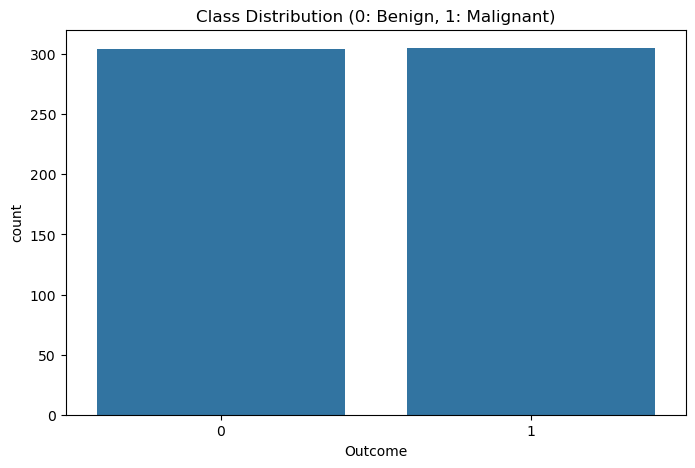

Class Distribution (%):
Outcome
1    50.082102
0    49.917898
Name: proportion, dtype: float64


In [56]:
# Class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Outcome')
plt.title('Class Distribution (0: Benign, 1: Malignant)')
plt.show()

# Percentage breakdown
class_dist = df['Outcome'].value_counts(normalize=True) * 100
print(f"Class Distribution (%):\n{class_dist}")

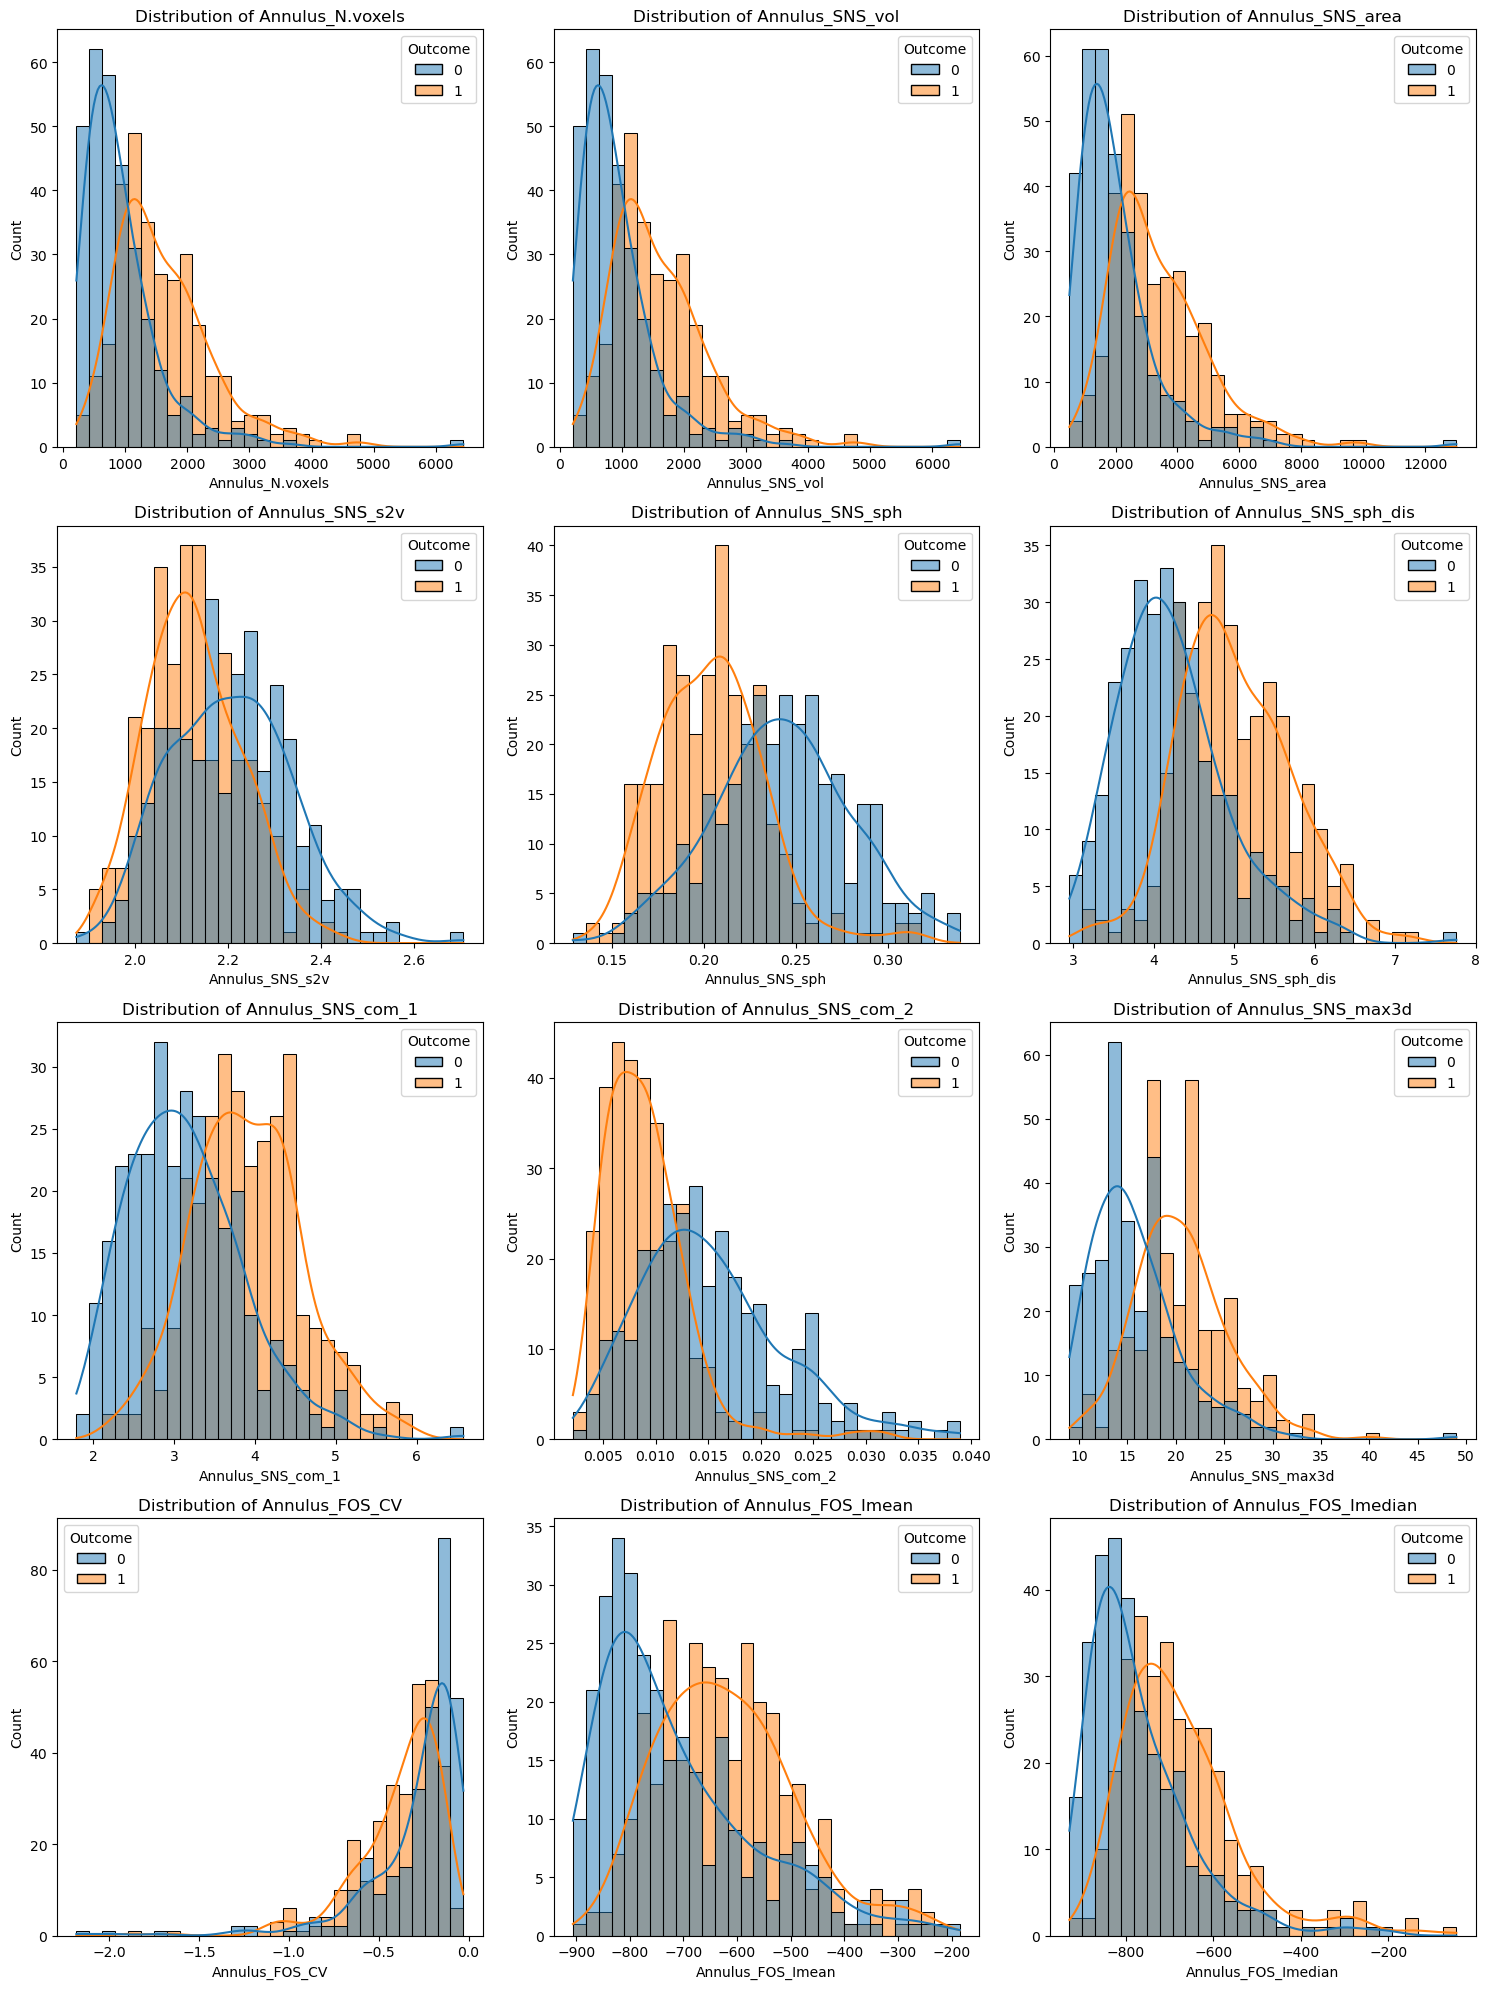

In [57]:
# Select numeric columns (excluding Outcome)
numeric_cols = df.select_dtypes(include=np.number).columns.drop('Outcome')

# Plot distributions
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_cols[:12]):  # First 12 for brevity
    plt.subplot(4, 3, i+1)
    sns.histplot(data=df, x=col, kde=True, hue='Outcome', bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

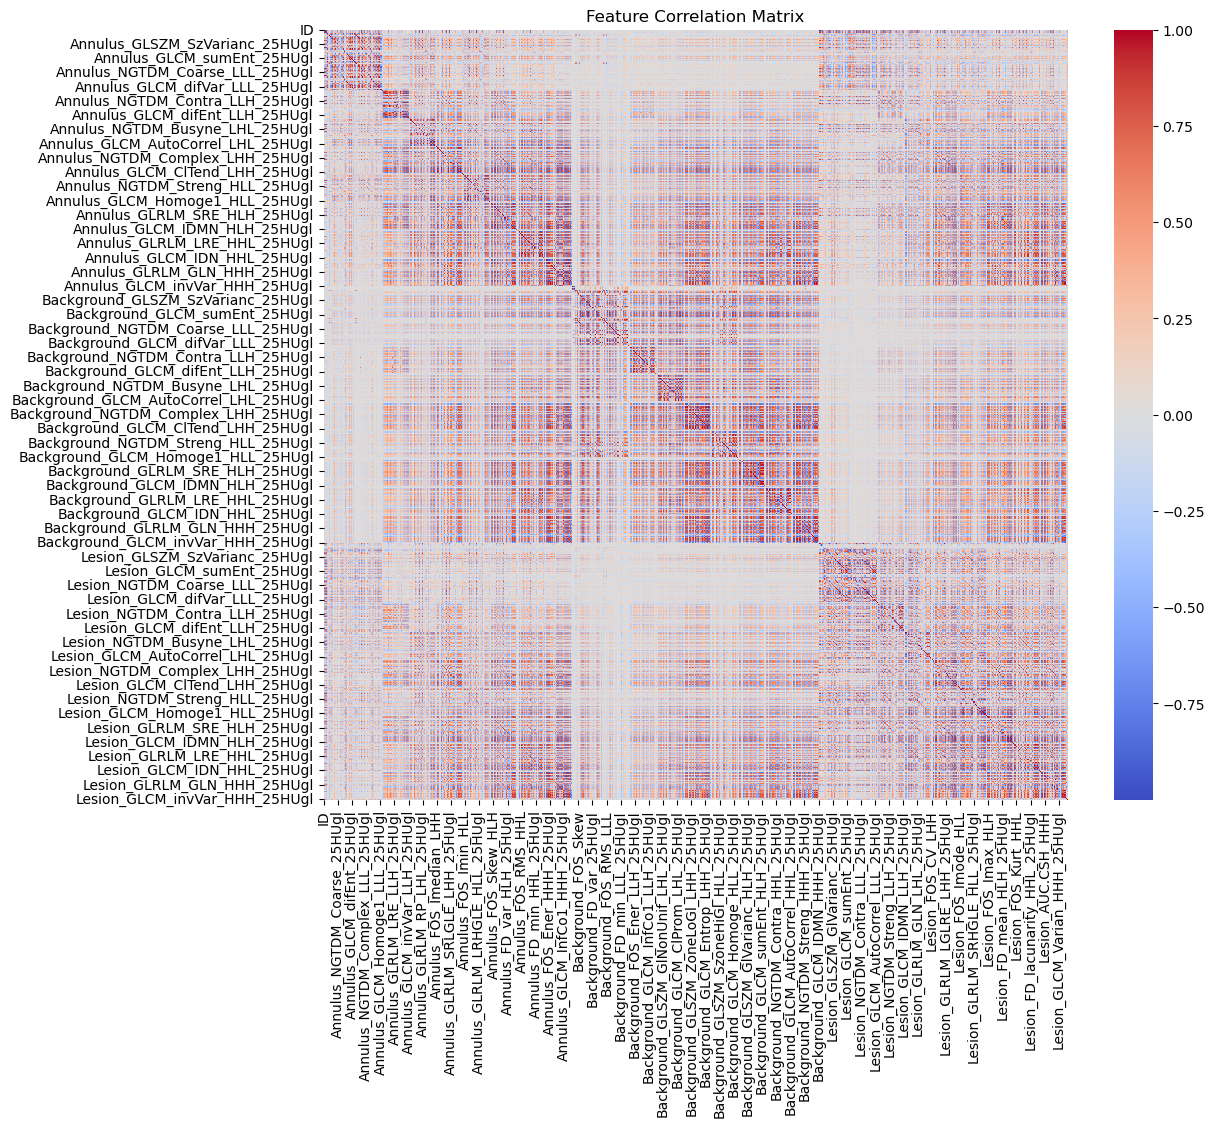

Top 10 Features Correlated with Outcome:
Outcome                           1.000000
Lesion_GLCM_InfCo2_LHL_25HUgl     0.537605
Annulus_GLCM_Entrop_LLL_25HUgl    0.534242
Lesion_GLCM_InfCo2_HLL_25HUgl     0.516611
Lesion_GLCM_IDMN_LLL_25HUgl       0.513468
Lesion_GLCM_IDMN_25HUgl           0.508392
Lesion_GLCM_InfCo2_LLH_25HUgl     0.505760
Lesion_GLCM_InfCo2_LHH_25HUgl     0.504480
Lesion_GLCM_IDN_LLL_25HUgl        0.503877
Lesion_GLCM_InfCo1_LLL_25HUgl     0.498689
Name: Outcome, dtype: float64


In [58]:
# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Top correlations with Outcome
outcome_corr = corr_matrix['Outcome'].abs().sort_values(ascending=False)
print("Top 10 Features Correlated with Outcome:")
print(outcome_corr.head(10))

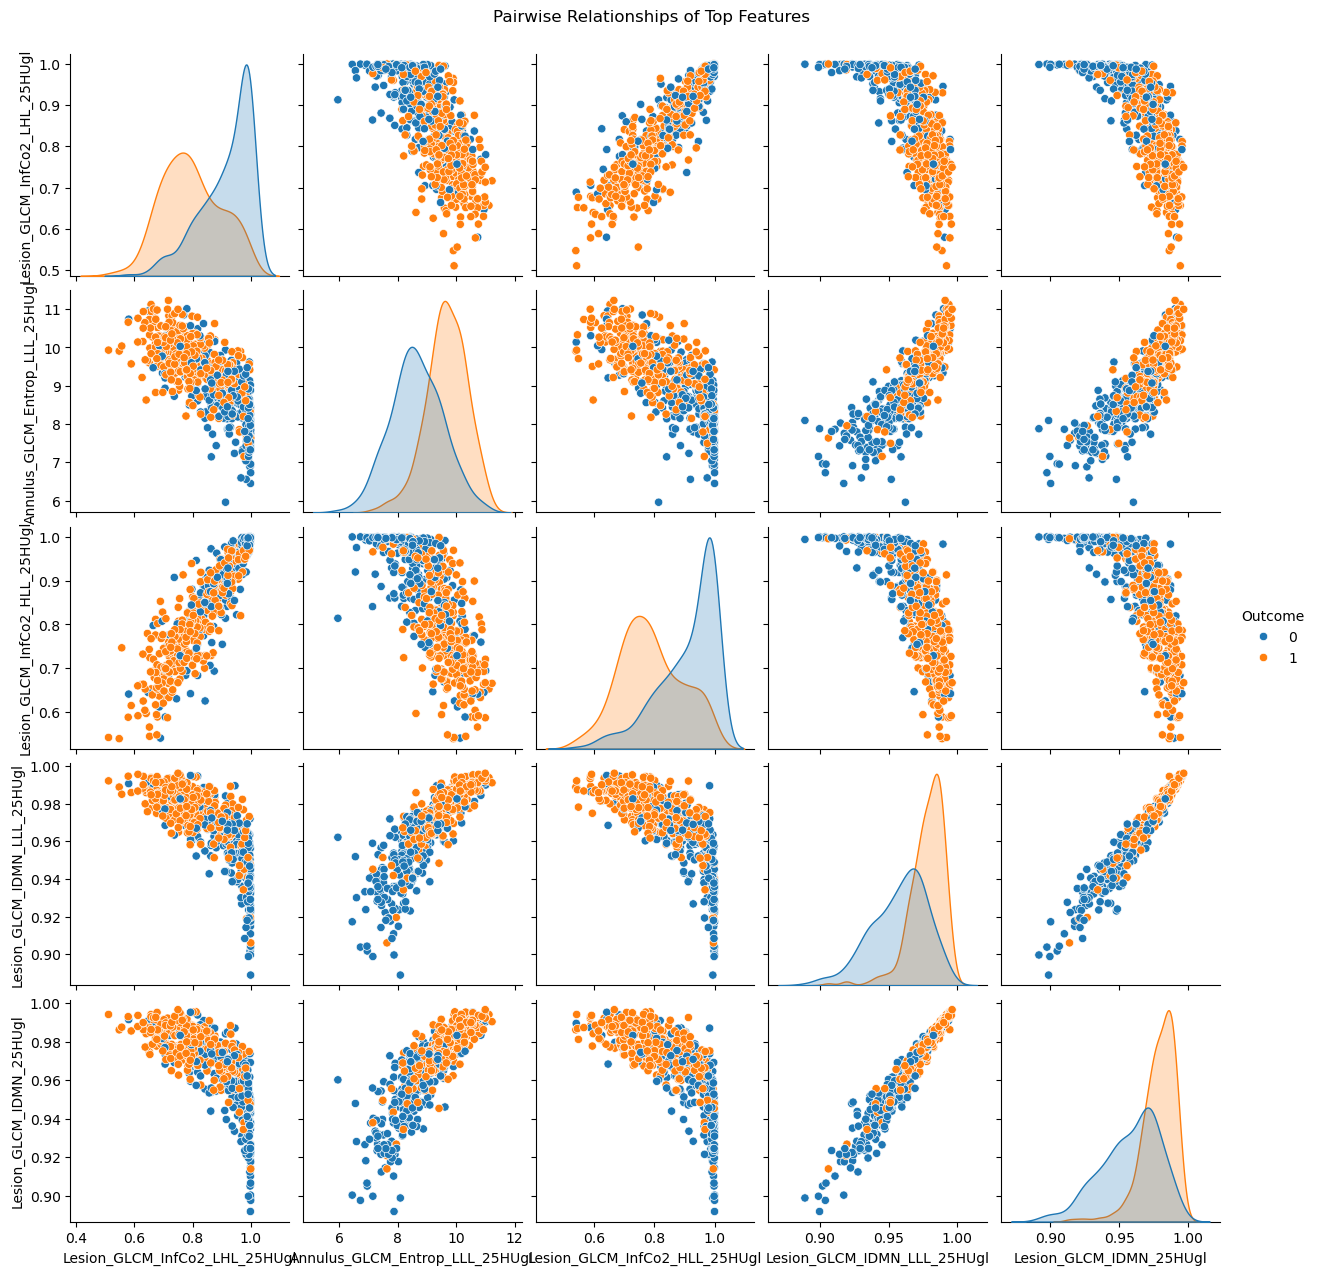

In [59]:
top_features = outcome_corr.index[1:6]  # Exclude Outcome itself
sns.pairplot(data=df[list(top_features) + ['Outcome']], hue='Outcome')
plt.suptitle('Pairwise Relationships of Top Features', y=1.02)
plt.show()

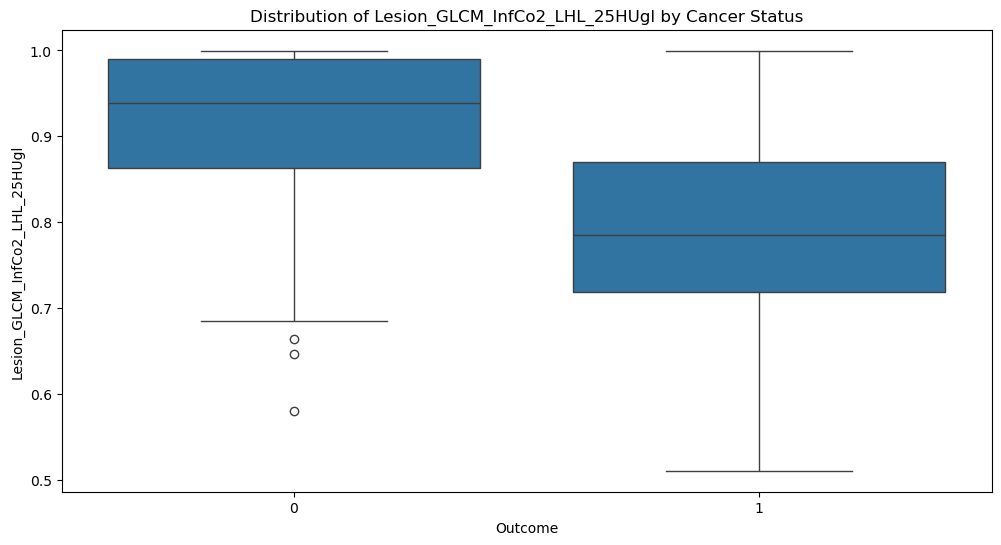

In [60]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Outcome', y=top_features[0])  
plt.title(f'Distribution of {top_features[0]} by Cancer Status')
plt.show()

In [61]:
# Check for duplicates
print(f"Duplicate Rows: {df.duplicated().sum()}")

# Examine zeros/missing values
print("\nFeatures with >30% zeros:")
print((df[numeric_cols] == 0).mean().sort_values(ascending=False).head(10))

Duplicate Rows: 0

Features with >30% zeros:
Lesion_FOS_Imode           0.011494
Annulus_FOS_Imode          0.006568
Annulus_FOS_Imode_LLL      0.001642
Annulus_FOS_Imedian_HLH    0.001642
Annulus_FOS_Imedian_LHH    0.001642
Annulus_FOS_Imode_LHH      0.001642
Annulus_FOS_Imode_HLL      0.001642
Annulus_FOS_Imode_HLH      0.001642
Annulus_FOS_Imode_HHL      0.001642
Annulus_FOS_Imode_HHH      0.001642
dtype: float64


## Data Processing

In [62]:
def non_matching_columns(dataset_one, dataset_two):
    non_matching = []
    dataset_one_cols = dataset_one.columns
    dataset_two_cols = dataset_two.columns
    
    for index in range(len(dataset_one_cols)):
        if dataset_one_cols[index] != dataset_two_cols[index]:
            non_matching.append((dataset_one_cols[index], dataset_two_cols[index]))

    return non_matching

In [63]:
# Check for column name inconsistency between the training and test data
non_matching = non_matching_columns(train_data, test_data)

print("Number of Non-Matching Columns: ", len(non_matching))
print("Non-Matching Columns:\n", non_matching)

Number of Non-Matching Columns:  30
Non-Matching Columns:
 [('Annulus_N.voxels', 'Annulus_N voxels'), ('Annulus_AUC.CSH', 'Annulus_AUC-CSH'), ('Annulus_AUC.CSH_LLL', 'Annulus_AUC-CSH_LLL'), ('Annulus_AUC.CSH_LLH', 'Annulus_AUC-CSH_LLH'), ('Annulus_AUC.CSH_LHL', 'Annulus_AUC-CSH_LHL'), ('Annulus_AUC.CSH_LHH', 'Annulus_AUC-CSH_LHH'), ('Annulus_AUC.CSH_HLL', 'Annulus_AUC-CSH_HLL'), ('Annulus_AUC.CSH_HLH', 'Annulus_AUC-CSH_HLH'), ('Annulus_AUC.CSH_HHL', 'Annulus_AUC-CSH_HHL'), ('Annulus_AUC.CSH_HHH', 'Annulus_AUC-CSH_HHH'), ('Background_N.voxels', 'Background_N voxels'), ('Background_AUC.CSH', 'Background_AUC-CSH'), ('Background_AUC.CSH_LLL', 'Background_AUC-CSH_LLL'), ('Background_AUC.CSH_LLH', 'Background_AUC-CSH_LLH'), ('Background_AUC.CSH_LHL', 'Background_AUC-CSH_LHL'), ('Background_AUC.CSH_LHH', 'Background_AUC-CSH_LHH'), ('Background_AUC.CSH_HLL', 'Background_AUC-CSH_HLL'), ('Background_AUC.CSH_HLH', 'Background_AUC-CSH_HLH'), ('Background_AUC.CSH_HHL', 'Background_AUC-CSH_HHL'), ('

In [64]:
def standardize_colnames(df):
    df.columns = df.columns.str.replace(r'(\.| )', '-', regex=True)  # Replace both dots and spaces with hyphens
    return df

# Apply to both datasets
train_data = standardize_colnames(train_data)
test_data = standardize_colnames(test_data)

In [65]:
# After fixing, verify alignment
assert set(train_data.columns) == set(test_data.columns), "Columns still don't match!"
print("All columns now match!")

All columns now match!


In [66]:
# Select top 10 correlated features + Outcome
top_features = outcome_corr.index[:11].tolist()  # Includes Outcome
df_filtered = df[top_features]

In [67]:
# df['log_Lesion_GLCM_InfCo2_LHL'] = np.log1p(df['Lesion_GLCM_InfCo2_LHL_25HUgl'])

In [68]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", cat_cols.tolist())

Categorical columns: ['ID']


In [69]:
df = df.drop('ID', axis=1)

In [70]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print("Remaining categorical columns:", cat_cols.tolist())  

Remaining categorical columns: []


In [71]:
if len(cat_cols) > 0:
    
    # Correct modern syntax (sparse_output=False instead of sparse=False)
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_cols = encoder.fit_transform(df[cat_cols])
    
    # Create DataFrame with new encoded columns
    encoded_df = pd.DataFrame(
        encoded_cols,
        columns=encoder.get_feature_names_out(cat_cols)
    )
    
    # Combine with numeric columns
    df_processed = pd.concat([
        df.drop(cat_cols, axis=1),
        encoded_df
    ], axis=1)
else:
    df_processed = df.copy()

In [72]:
print("\nProcessed Data Shape:", df_processed.shape)
display(df_processed.head(2))


Processed Data Shape: (609, 1999)


Annulus_N.voxels  Annulus_SNS_vol  Annulus_SNS_area  Annulus_SNS_s2v  \
0              1504             1504              3364         2.236702   
1              1007             1007              2224         2.208540   

   Annulus_SNS_sph  Annulus_SNS_sph_dis  Annulus_SNS_com_1  Annulus_SNS_com_2  \
0         0.188709             5.299155           3.779511           0.006720   
1         0.218459             4.577528           3.334505           0.010426   

   Annulus_SNS_max3d  Annulus_FOS_CV  ...  Lesion_GLCM_sumEnt_HHH_25HUgl  \
0                 21       -0.134648  ...                       1.456343   
1                 16       -0.181334  ...                       1.462379   

   Lesion_GLCM_difVar_HHH_25HUgl  Lesion_GLCM_difEnt_HHH_25HUgl  \
0                       0.516489                       1.478822   
1                       0.535239                       1.502895   

   Lesion_GLCM_AutoCorrel_HHH_25HUgl  Lesion_GLCM_ClTend_HHH_25HUgl  \
0                          12.359264                       1.122325   
1                          12.134616                       1.132018   

   Lesion_GLCM_Homoge1_HHH_25HUgl  Lesion_GLCM_IDMN_HHH_25HUgl  \
0                        0.672912                     0.972564   
1                        0.675078                     0.971933   

   Lesion_GLCM_IDN_HHH_25HUgl  Lesion_GLCM_invVar_HHH_25HUgl  Outcome  
0                    0.898164                       0.519051        0  
1                    0.898085                       0.502191        0  

[2 rows x 1999 columns]

### Scaling and Splitting Data

In [73]:
# Separate features and target
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

# Scale only numeric features (excluding Outcome)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_processed = pd.DataFrame(X_scaled, columns=X.columns)

In [74]:
'''
top_features = [
    'Outcome',
    'Lesion_GLCM_InfCo2_LHL_25HUgl',
    'Annulus_GLCM_Entrop_LLL_25HUgl',
    'Lesion_GLCM_InfCo2_HLL_25HUgl',
    'Lesion_GLCM_IDMN_LLL_25HUgl',
    'Lesion_GLCM_IDMN_25HUgl',
    'Lesion_GLCM_InfCo2_LLH_25HUgl',
    'Lesion_GLCM_InfCo2_LHH_25HUgl',
    'Lesion_GLCM_IDN_LLL_25HUgl',
    'Lesion_GLCM_InfCo1_LLL_25HUgl'
]
df_final = df[top_features]
'''

"\ntop_features = [\n    'Outcome',\n    'Lesion_GLCM_InfCo2_LHL_25HUgl',\n    'Annulus_GLCM_Entrop_LLL_25HUgl',\n    'Lesion_GLCM_InfCo2_HLL_25HUgl',\n    'Lesion_GLCM_IDMN_LLL_25HUgl',\n    'Lesion_GLCM_IDMN_25HUgl',\n    'Lesion_GLCM_InfCo2_LLH_25HUgl',\n    'Lesion_GLCM_InfCo2_LHH_25HUgl',\n    'Lesion_GLCM_IDN_LLL_25HUgl',\n    'Lesion_GLCM_InfCo1_LLL_25HUgl'\n]\ndf_final = df[top_features]\n"

In [75]:
#X = df_final.drop('Outcome', axis=1)
#y = df_final['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [76]:
'''
# Get top 50 features most correlated with 'Outcome'
correlations = train_data.corr()['Outcome'].abs().sort_values(ascending=False)
top_50_features = correlations.head(50).index.tolist()

# Filter datasets
X_train = train_data[top_50_features]
y_train = train_data['Outcome']
X_test = test_data[top_50_features]
y_test = test_data['Outcome']
'''

"\n# Get top 50 features most correlated with 'Outcome'\ncorrelations = train_data.corr()['Outcome'].abs().sort_values(ascending=False)\ntop_50_features = correlations.head(50).index.tolist()\n\n# Filter datasets\nX_train = train_data[top_50_features]\ny_train = train_data['Outcome']\nX_test = test_data[top_50_features]\ny_test = test_data['Outcome']\n"

## Training Models

### XGB Classifier

In [52]:
model = XGBClassifier(
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),  # Handles slight imbalance
    eval_metric='logloss',
    n_estimators=200,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred_proba = model.predict_proba(X_test)[:,1]
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

Test ROC-AUC: 1.000


## Logistic Regression

In [77]:
# Linear Regression Model
lr_model = LogisticRegression(random_state=22)
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


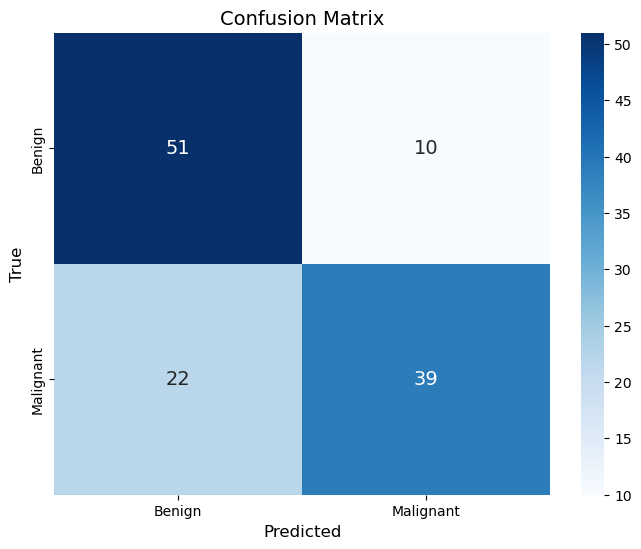


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 73.77%
Balanced Accuracy        : 73.77%
Precision (PPV)          : 79.59%
Recall (Sensitivity)     : 63.93%
Specificity              : 83.61%
F1 Score                 : 70.91%
MCC                      : 0.4849

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 22
False Positives (Overdiagnosis): 10
Sensitivity (True Positive Rate): 63.93%
Specificity (True Negative Rate): 83.61%


In [78]:
# Logistic Regression Evaluation
evaluate_medical_model(y_test, lr_y_pred)

## Random Forest 

In [81]:
# Random Forest Classifier Model
rf_model = RandomForestClassifier(random_state=22)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

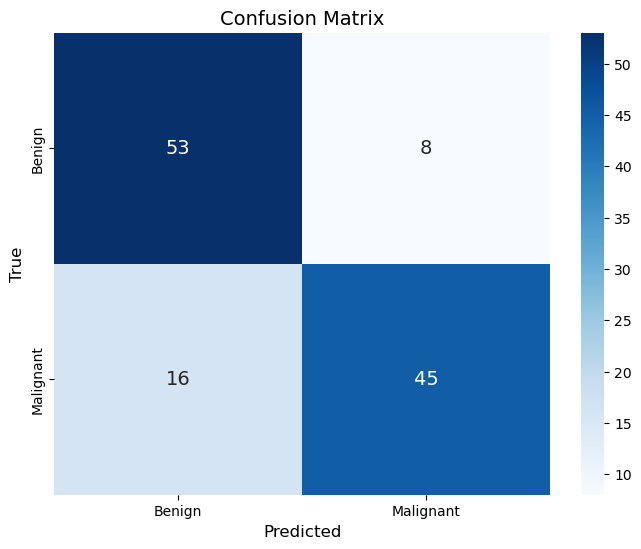


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 80.33%
Balanced Accuracy        : 80.33%
Precision (PPV)          : 84.91%
Recall (Sensitivity)     : 73.77%
Specificity              : 86.89%
F1 Score                 : 78.95%
MCC                      : 0.6118

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 16
False Positives (Overdiagnosis): 8
Sensitivity (True Positive Rate): 73.77%
Specificity (True Negative Rate): 86.89%


In [82]:
# Random Forest Evaluation
evaluate_medical_model(y_test, rf_y_pred)

## XGB 

In [83]:
# XGB Model
xgb_model = XGBClassifier(random_state=22)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

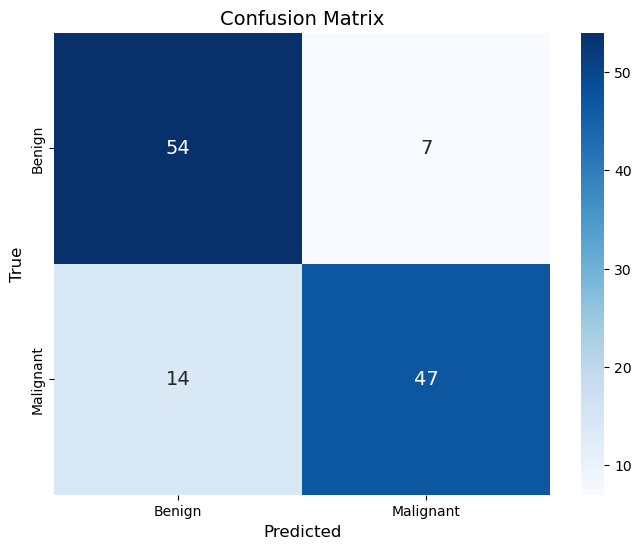


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 82.79%
Balanced Accuracy        : 82.79%
Precision (PPV)          : 87.04%
Recall (Sensitivity)     : 77.05%
Specificity              : 88.52%
F1 Score                 : 81.74%
MCC                      : 0.6601

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 14
False Positives (Overdiagnosis): 7
Sensitivity (True Positive Rate): 77.05%
Specificity (True Negative Rate): 88.52%


In [84]:
# Random Forest Evaluation
evaluate_medical_model(y_test, xgb_y_pred)

In [85]:
# Use Bayesian Optimization to find the best set of hyperparameters
xgb_params = {"n_estimators": (10, 500), 
              "eta": (0.0001, 1),
              "max_depth": (1, 9), 
              "subsample": (0.1, 1), 
              "colsample_bytree": (0.1, 1)}

xgb_opt = BayesSearchCV(XGBClassifier(random_state=22), xgb_params, verbose=3, n_iter=100)
xgb_opt.fit(X_train, y_train)
xgb_opt.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.6971339889160593, eta=0.28576573507335706, max_depth=4, n_estimators=38, subsample=0.12676379010221073;, score=0.673 total time=   1.5s
[CV 2/5] END colsample_bytree=0.6971339889160593, eta=0.28576573507335706, max_depth=4, n_estimators=38, subsample=0.12676379010221073;, score=0.704 total time=   1.3s
[CV 3/5] END colsample_bytree=0.6971339889160593, eta=0.28576573507335706, max_depth=4, n_estimators=38, subsample=0.12676379010221073;, score=0.732 total time=   1.2s
[CV 4/5] END colsample_bytree=0.6971339889160593, eta=0.28576573507335706, max_depth=4, n_estimators=38, subsample=0.12676379010221073;, score=0.701 total time=   1.2s
[CV 5/5] END colsample_bytree=0.6971339889160593, eta=0.28576573507335706, max_depth=4, n_estimators=38, subsample=0.12676379010221073;, score=0.680 total time=   1.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.3769758361

OrderedDict([('colsample_bytree', 0.7149121162894011),
             ('eta', 0.0001),
             ('max_depth', 8),
             ('n_estimators', 397),
             ('subsample', 0.7890158963408485)])

In [87]:
# XGB Model
print(xgb_opt.best_estimator_)
xgb_model_tuned = xgb_opt.best_estimator_
xgb_tuned_y_pred = xgb_model_tuned.predict(X_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7149121162894011, device=None,
              early_stopping_rounds=None, enable_categorical=False, eta=0.0001,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=397, n_jobs=None, ...)


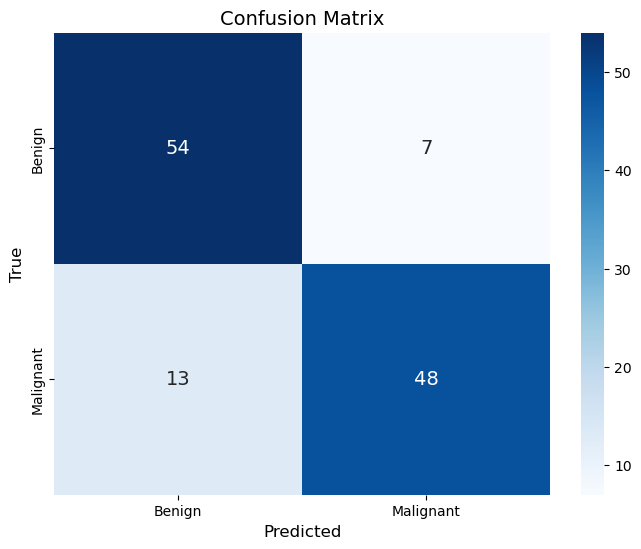


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 83.61%
Balanced Accuracy        : 83.61%
Precision (PPV)          : 87.27%
Recall (Sensitivity)     : 78.69%
Specificity              : 88.52%
F1 Score                 : 82.76%
MCC                      : 0.6754

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 13
False Positives (Overdiagnosis): 7
Sensitivity (True Positive Rate): 78.69%
Specificity (True Negative Rate): 88.52%


In [88]:
# Random Forest Evaluation
evaluate_medical_model(y_test, xgb_tuned_y_pred)

### Random Forest Classifier

In [53]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# Feature importance visualization
pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

Feature  Importance
0                              Outcome    0.424308
29  Annulus_GLSZM_SzNonUnif_LLL_25HUgl    0.050791
2       Annulus_GLCM_Entrop_LLL_25HUgl    0.042643
44  Annulus_GLSZM_GlVarianc_LLL_25HUgl    0.032845
41            Annulus_GLRLM_RLN_25HUgl    0.031759
7        Lesion_GLCM_InfCo2_LHH_25HUgl    0.028898
14       Lesion_GLCM_InfCo1_HLL_25HUgl    0.026733
1        Lesion_GLCM_InfCo2_LHL_25HUgl    0.023159
4          Lesion_GLCM_IDMN_LLL_25HUgl    0.016981
21     Annulus_NGTDM_Coarse_HHH_25HUgl    0.015503

### Logistic Regression

In [54]:
model = LogisticRegression(
    penalty='l1',  # L1 regularization for feature selection
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# View coefficients
pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

Feature  Coefficient
0                              Outcome    11.049671
2       Annulus_GLCM_Entrop_LLL_25HUgl    -0.394277
10       Lesion_GLCM_Dissim_LLL_25HUgl    -0.074464
32       Lesion_GLCM_difVar_LLL_25HUgl    -0.007587
29  Annulus_GLSZM_SzNonUnif_LLL_25HUgl     0.001714
44  Annulus_GLSZM_GlVarianc_LLL_25HUgl    -0.001657
12       Lesion_GLCM_Contra_LLL_25HUgl    -0.001333
41            Annulus_GLRLM_RLN_25HUgl    -0.000496
1        Lesion_GLCM_InfCo2_LHL_25HUgl     0.000000
3        Lesion_GLCM_InfCo2_HLL_25HUgl     0.000000
9        Lesion_GLCM_InfCo1_LLL_25HUgl     0.000000
8           Lesion_GLCM_IDN_LLL_25HUgl     0.000000
11                     Annulus_SNS_sph     0.000000
13              Lesion_GLCM_IDN_25HUgl     0.000000
6        Lesion_GLCM_InfCo2_LLH_25HUgl     0.000000
7        Lesion_GLCM_InfCo2_LHH_25HUgl     0.000000
4          Lesion_GLCM_IDMN_LLL_25HUgl     0.000000
5              Lesion_GLCM_IDMN_25HUgl     0.000000
17       Lesion_GLCM_InfCo1_LHL_25HUgl     0.000000
16                   Annulus_SNS_com_1     0.000000
15                 Annulus_SNS_sph_dis     0.000000
14       Lesion_GLCM_InfCo1_HLL_25HUgl     0.000000
22     Annulus_NGTDM_Coarse_HHL_25HUgl     0.000000
23     Annulus_NGTDM_Coarse_LHH_25HUgl     0.000000
18       Lesion_GLCM_InfCo2_HLH_25HUgl     0.000000
19                   Annulus_SNS_com_2     0.000000
25           Lesion_GLCM_Dissim_25HUgl     0.000000
24          Annulus_GLCM_Entrop_25HUgl     0.000000
27          Lesion_GLCM_IDN_LLH_25HUgl     0.000000
26      Annulus_GLCM_sumEnt_LLL_25HUgl     0.000000
28       Lesion_GLCM_InfCo2_HHL_25HUgl     0.000000
30          Lesion_GLCM_IDN_HLH_25HUgl     0.000000
20     Annulus_NGTDM_Coarse_HLH_25HUgl     0.000000
21     Annulus_NGTDM_Coarse_HHH_25HUgl     0.000000
33     Annulus_NGTDM_Coarse_LLH_25HUgl     0.000000
31       Lesion_GLCM_Correl_LLL_25HUgl     0.000000
36       Lesion_GLSZM_SmallZone_25HUgl     0.000000
34           Lesion_FD_mean_LLL_25HUgl     0.000000
37       Lesion_GLSZM_ZonePcent_25HUgl     0.000000
38           Lesion_GLCM_InfCo1_25HUgl     0.000000
39           Lesion_GLCM_Correl_25HUgl     0.000000
35   Lesion_GLSZM_ZonePcent_LLH_25HUgl     0.000000
40           Lesion_GLCM_Contra_25HUgl     0.000000
42      Lesion_GLCM_Homoge1_LLH_25HUgl     0.000000
43          Lesion_NGTDM_Contra_25HUgl     0.000000
45       Lesion_GLCM_Homoge_LLH_25HUgl     0.000000
46         Lesion_GLCM_IDMN_HLL_25HUgl     0.000000
47          Lesion_GLCM_IDN_LHH_25HUgl     0.000000
48     Annulus_NGTDM_Coarse_HLL_25HUgl     0.000000
49      Lesion_NGTDM_Coarse_LLH_25HUgl     0.000000

#### Neural Network GPU Intensive

In [55]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # Helps prevent overfitting
    Dense(1, activation='sigmoid')  # Single output neuron for binary classification
])

# Compile with medical-appropriate settings
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='roc_auc'),  # Critical for medical diagnostics
        'accuracy'
    ]
)

# Train with validation split
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight={0: 1, 1: 1.1}  # Optional: Adjust if you have class imbalance
)

# Evaluate
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

Epoch 1/50


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6877 - loss: 33.9987 - roc_auc: 0.7010 - val_accuracy: 0.7213 - val_loss: 10.9536 - val_roc_auc: 0.7699
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7045 - loss: 19.4074 - roc_auc: 0.7069 - val_accuracy: 0.7213 - val_loss: 8.5377 - val_roc_auc: 0.7690
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6710 - loss: 18.5438 - roc_auc: 0.6756 - val_accuracy: 0.7459 - val_loss: 5.0124 - val_roc_auc: 0.7787
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6755 - loss: 17.0021 - roc_auc: 0.6886 - val_accuracy: 0.7787 - val_loss: 3.4654 - val_roc_auc: 0.8045
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6342 - loss: 13.7498 - roc_auc: 0.6639 - val_accuracy: 0.7377 - val_loss: 4.0754 - val_roc_auc: 0.7782
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6290 - loss: 12.8717 - roc_auc: 0.6559 - val_accuracy: 0.7541 - val_loss: 3.4319 - val_roc_auc: 0.7805
Epoc

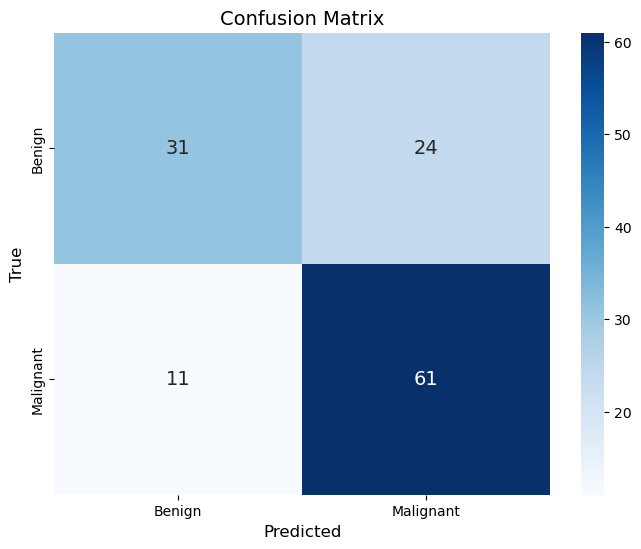


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 72.44%
Balanced Accuracy        : 70.54%
Precision (PPV)          : 71.76%
Recall (Sensitivity)     : 84.72%
Specificity              : 56.36%
F1 Score                 : 77.71%
MCC                      : 0.4327
ROC-AUC                  : 0.7467

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 11
False Positives (Overdiagnosis): 24
Sensitivity (True Positive Rate): 84.72%
Specificity (True Negative Rate): 56.36%


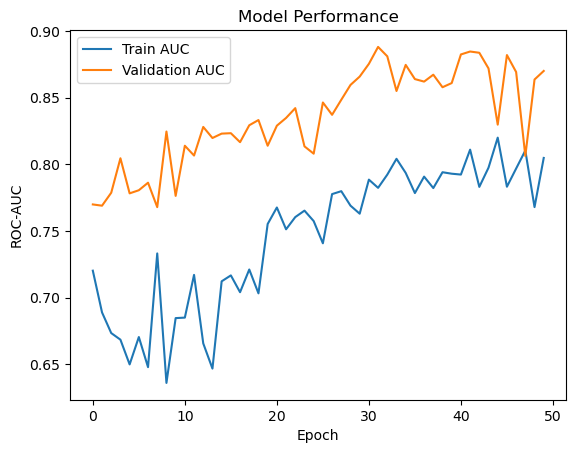

In [56]:
# With your evaluation function
evaluate_medical_model(y_test, y_pred, y_pred_proba)

# Or plot training history
plt.plot(history.history['roc_auc'], label='Train AUC')
plt.plot(history.history['val_roc_auc'], label='Validation AUC')
plt.title('Model Performance')
plt.ylabel('ROC-AUC')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Evaluation Metrics for Medical Use

In [57]:
# For binary classification threshold = 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)  

print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

NameError: name 'classification_report' is not defined

#### Shap

In [58]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Feature importance plot
shap.summary_plot(shap_values, X_test, plot_type='bar')

# Individual prediction explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'keras.src.models.sequential.Sequential'>

In [59]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validated ROC-AUC: {scores.mean():.3f} (±{scores.std():.3f})")

TypeError: Cannot clone object '<Sequential name=sequential, built=True>' (type <class 'keras.src.models.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.